# Betti vector $L_1$ norms as an estimate of chaos


## Set up data and functions

In [38]:
import pickle
import numpy as np
from functools import partial
from teaspoon.TDA.SLSP import Persistence0D
from teaspoon.TDA.Persistence import BettiCurve
from trajectories import generate_trajectories
from plots_and_correlates import plot_lce_estimate_and_correlation
from lca_supervised_learning import score_classification
from lca_supervised_learning import score_regression
from lca_supervised_learning import score_regression_pos
from lca_supervised_learning import score_regression_KNN
from lca_supervised_learning import score_regression_pos_KNN


In [39]:
import ipyparallel as ipp
clients = ipp.Client()
dv = clients.direct_view()
lbv = clients.load_balanced_view()

In [40]:
SEED = 42
SAMPLES = 500
LENGTH = 500
LENGTHS = [LENGTH]
experimental_data_all = {}
for length in LENGTHS:
    experimental_data_all |= {
        (SEED, length, SAMPLES): generate_trajectories(
            RANDOM_SEED=SEED, TS_LENGTH=length, CONTROL_PARAM_SAMPLES=SAMPLES
        )
    }


Experiment config -- SEED:42, LENGTH:500, SAMPLES:500


In [41]:
time_series_length = LENGTH
experimental_data = experimental_data_all[42, time_series_length, 500]

In [42]:
logistic_trajectories = experimental_data["logistic"]["trajectories"]
logistic_lces = experimental_data["logistic"]["lces"]
logistic_control_params = experimental_data["logistic"]["sys_params"]

In [43]:
henon_trajectories = experimental_data["henon"]["trajectories"]
henon_lces = experimental_data["henon"]["lces"]
henon_control_params = experimental_data["henon"]["sys_params"]

In [44]:
ikeda_trajectories = experimental_data["ikeda"]["trajectories"]
ikeda_lces = experimental_data["ikeda"]["lces"]
ikeda_control_params = experimental_data["ikeda"]["sys_params"]

In [45]:
tinkerbell_trajectories = experimental_data["tinkerbell"]["trajectories"]
tinkerbell_lces = experimental_data["tinkerbell"]["lces"]
tinkerbell_control_params = experimental_data["tinkerbell"]["sys_params"]

## Compute persistence diagrams, betti vectors, their norms, and their correlations with Lyapunov exponents

In [46]:
def generate_betti_norm_estimates(
    sys_name,
    param_name,
    trajectories,
    control_params,
    actual_lces,
    show_plot=True,
    save_plot=False
):
    # store results to be returned
    correlations_and_scores = {}

    # compute persistence diagrams
    pds = list(map(lambda ts: Persistence0D(ts)[2], trajectories))

    # compute betti vectors
    global_max = np.max(trajectories)
    num_stops = 100
    betti_vecs = list(map(partial(BettiCurve, maxEps=global_max, numStops=num_stops), pds))

    # take the norms
    betti_vec_norms = np.array(list(map(partial(np.linalg.norm, ord=1), betti_vecs)))

    # dictionary of our estimates
    laypunov_estimates = {
        r"Betti Vector L1 Norm": betti_vec_norms,
    }

    # compute the correlations of the estimates with the actual lyapunov values
    for estimate_name, estimates in laypunov_estimates.items():
        sequence_length = len(trajectories[0]) - 1
        correlations_and_scores[
            estimate_name, sys_name, sequence_length
        ] = plot_lce_estimate_and_correlation(
            estimate_name,
            sys_name,
            param_name,
            estimates,
            actual_lces,
            control_params,
            len(trajectories[0]) - 1,
            sharey=False,
            twoy=True,
            show_plot=show_plot,
            plot_actual=True,
            save_plot=save_plot
        )
        correlations_and_scores[
            estimate_name, sys_name, sequence_length
        ] |= {
            "classification_f1": score_classification(estimates.reshape(-1,1), actual_lces),
            "regression_neg_mean_absolute": score_regression(estimates.reshape(-1,1), actual_lces),
            "pos_regression_neg_mean_absolute": score_regression_pos(estimates.reshape(-1,1), actual_lces),
            "regression_neg_mean_absolute_poly": score_regression_KNN(estimates.reshape(-1,1), actual_lces),
            "pos_regression_neg_mean_absolute_poly": score_regression_pos_KNN(estimates.reshape(-1,1), actual_lces),
        }



    return correlations_and_scores


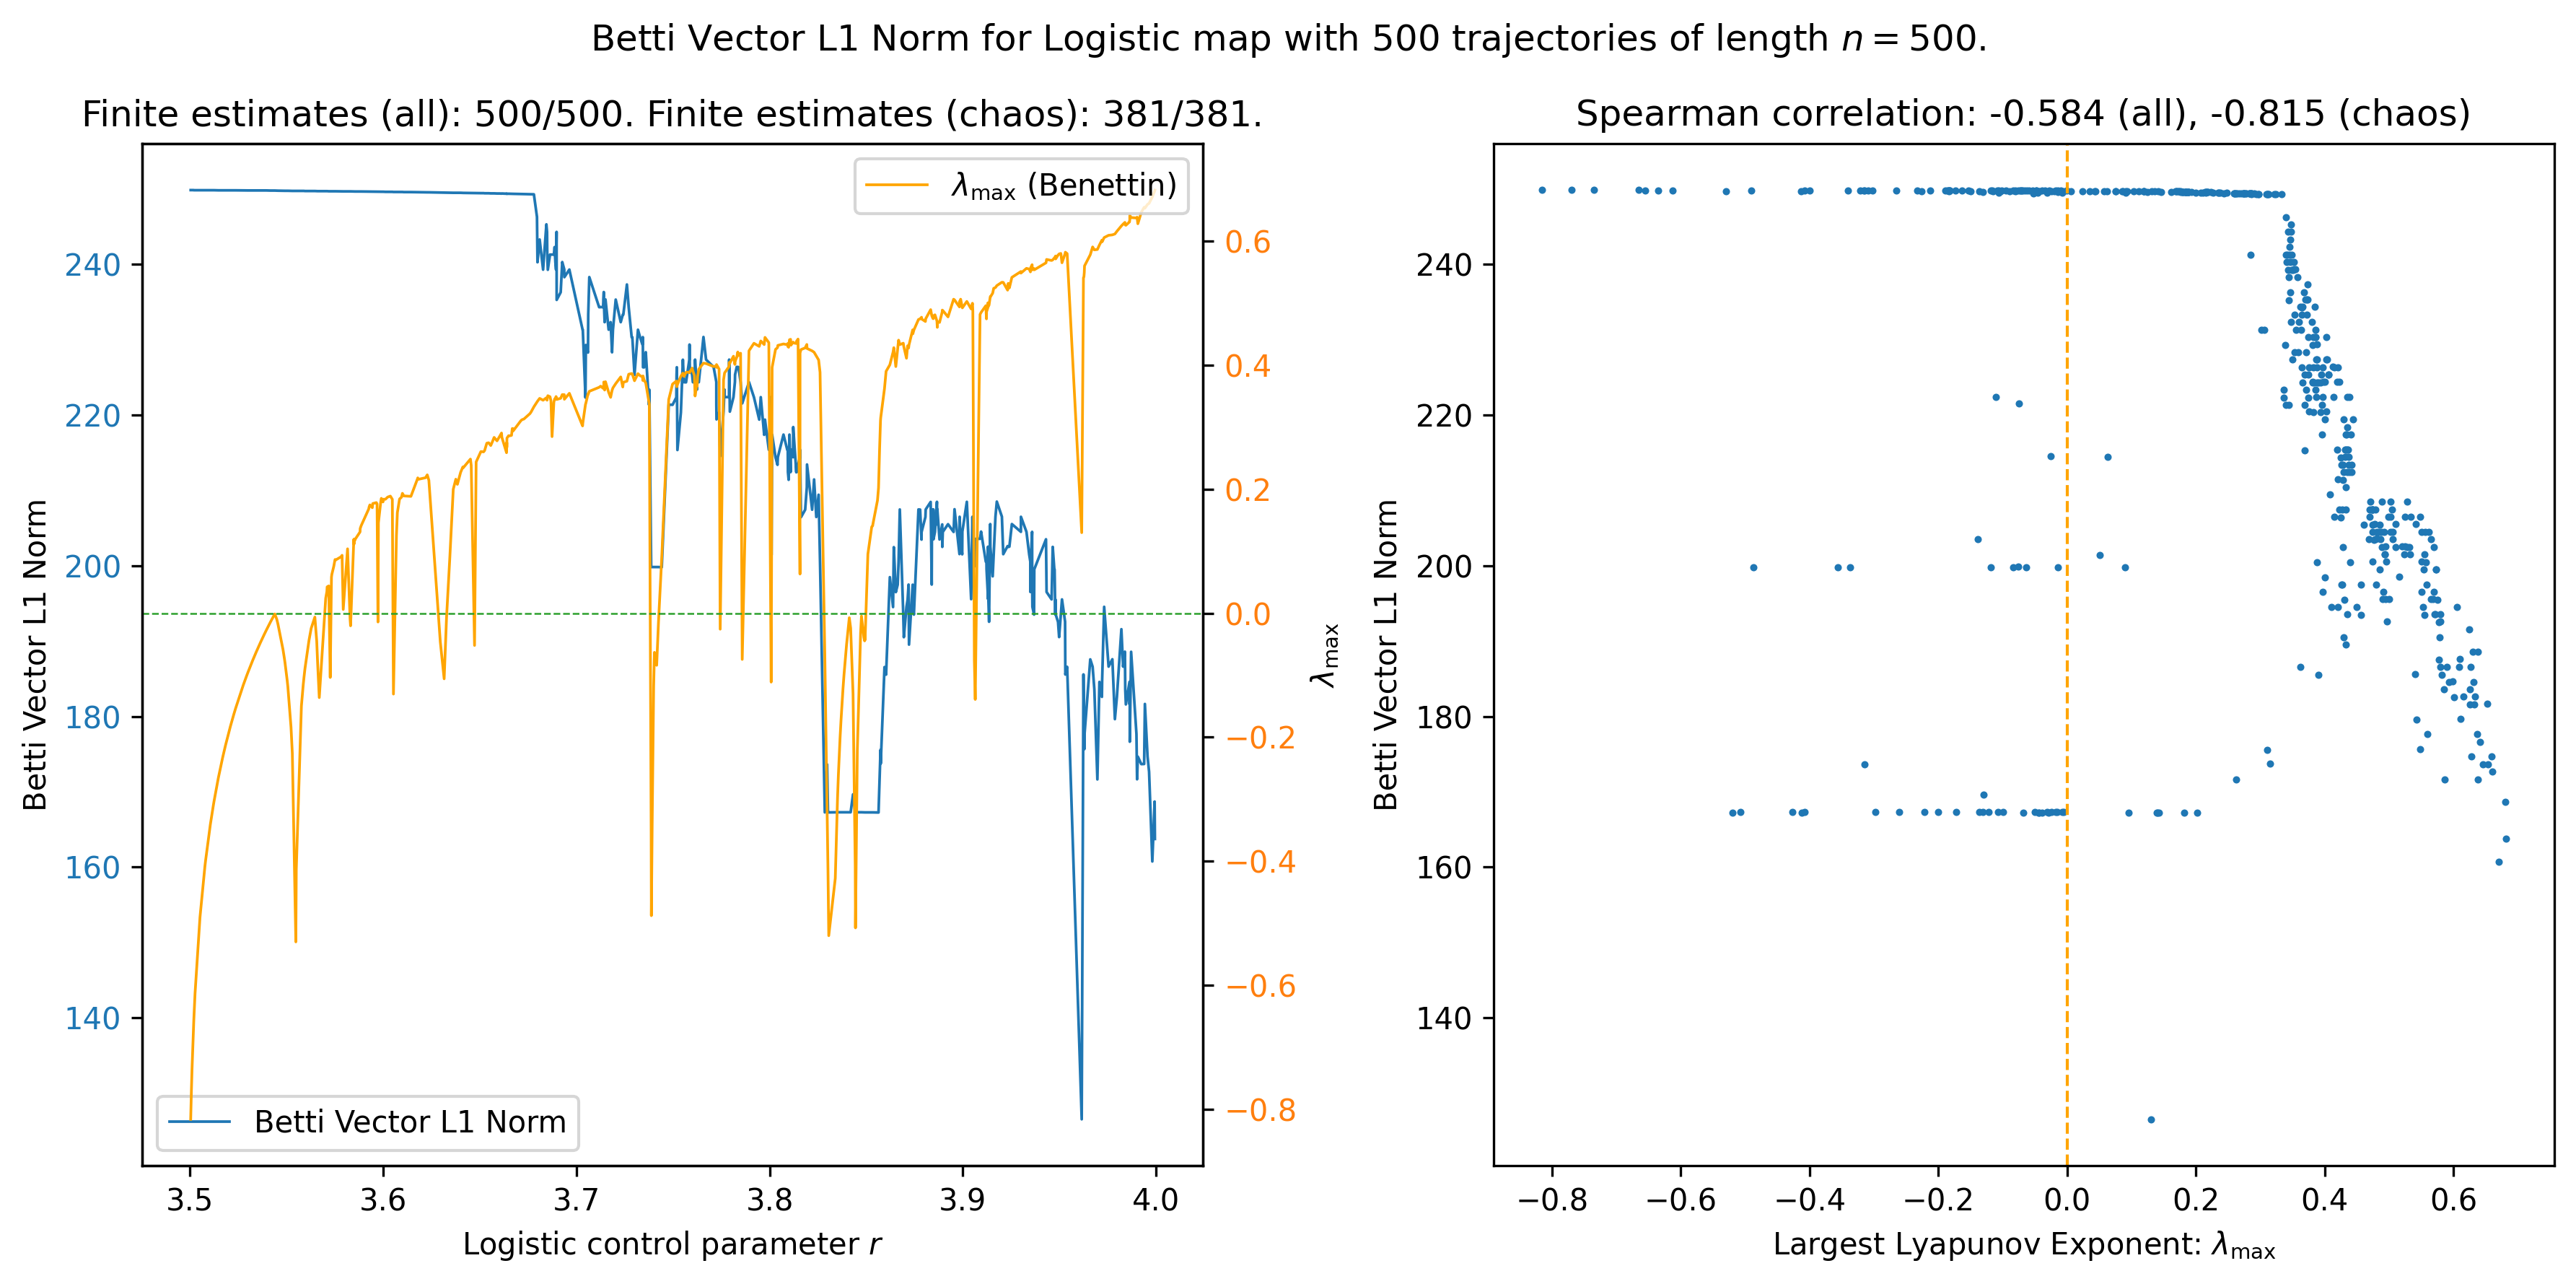

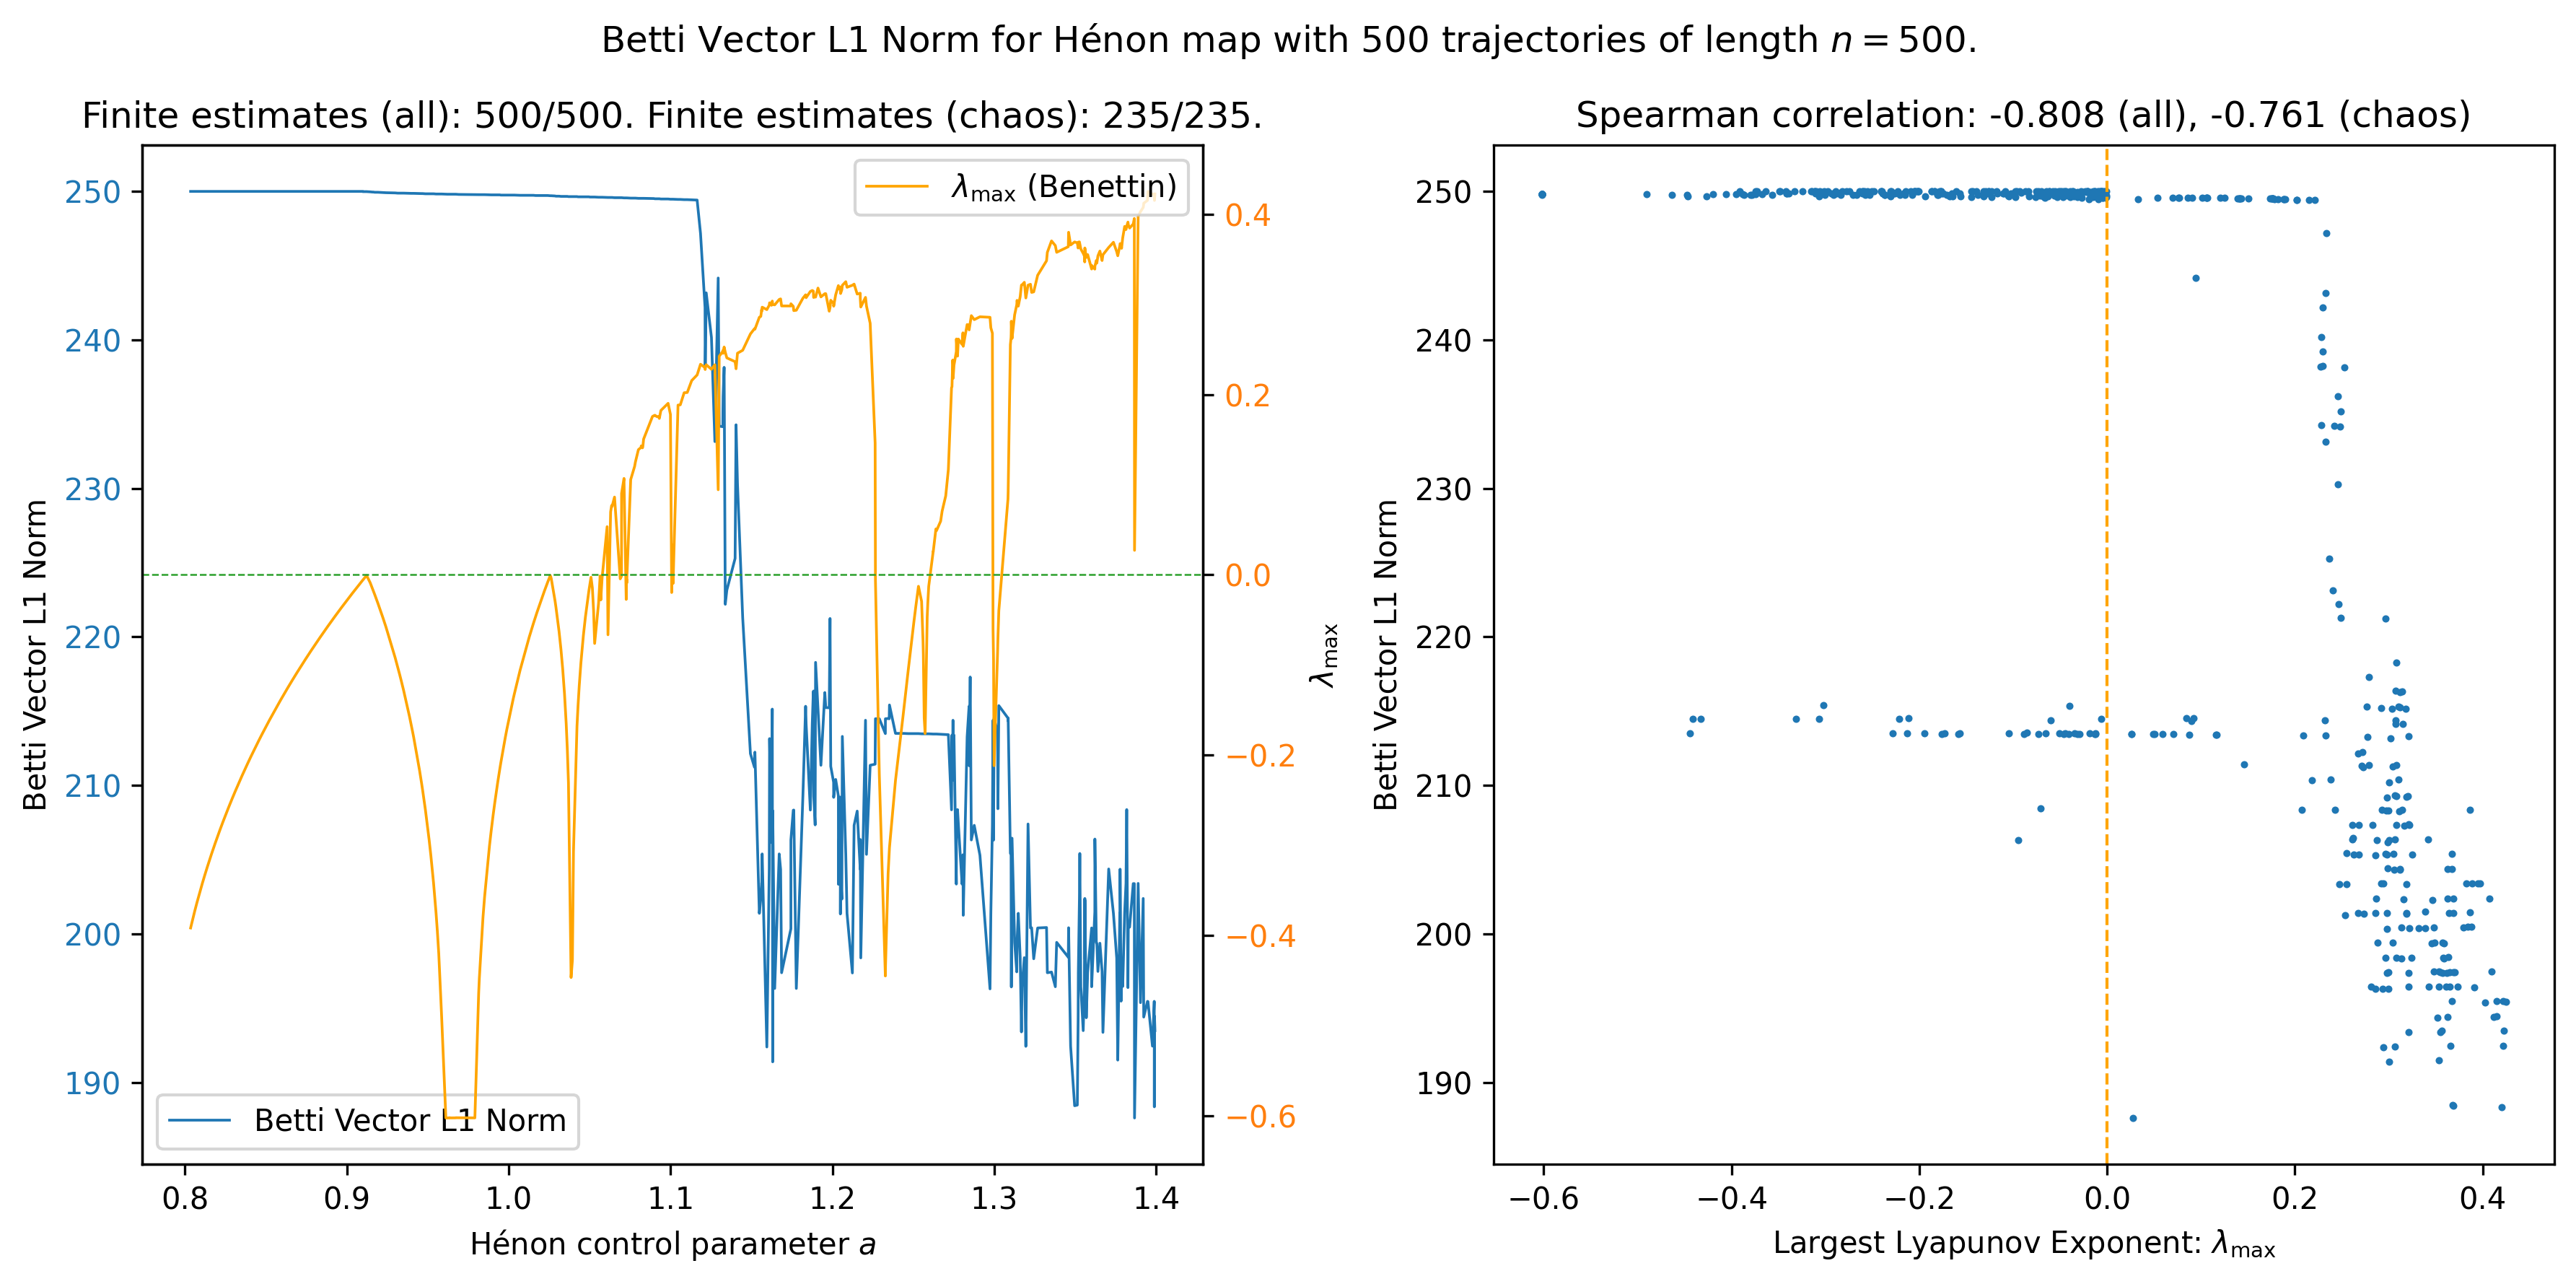

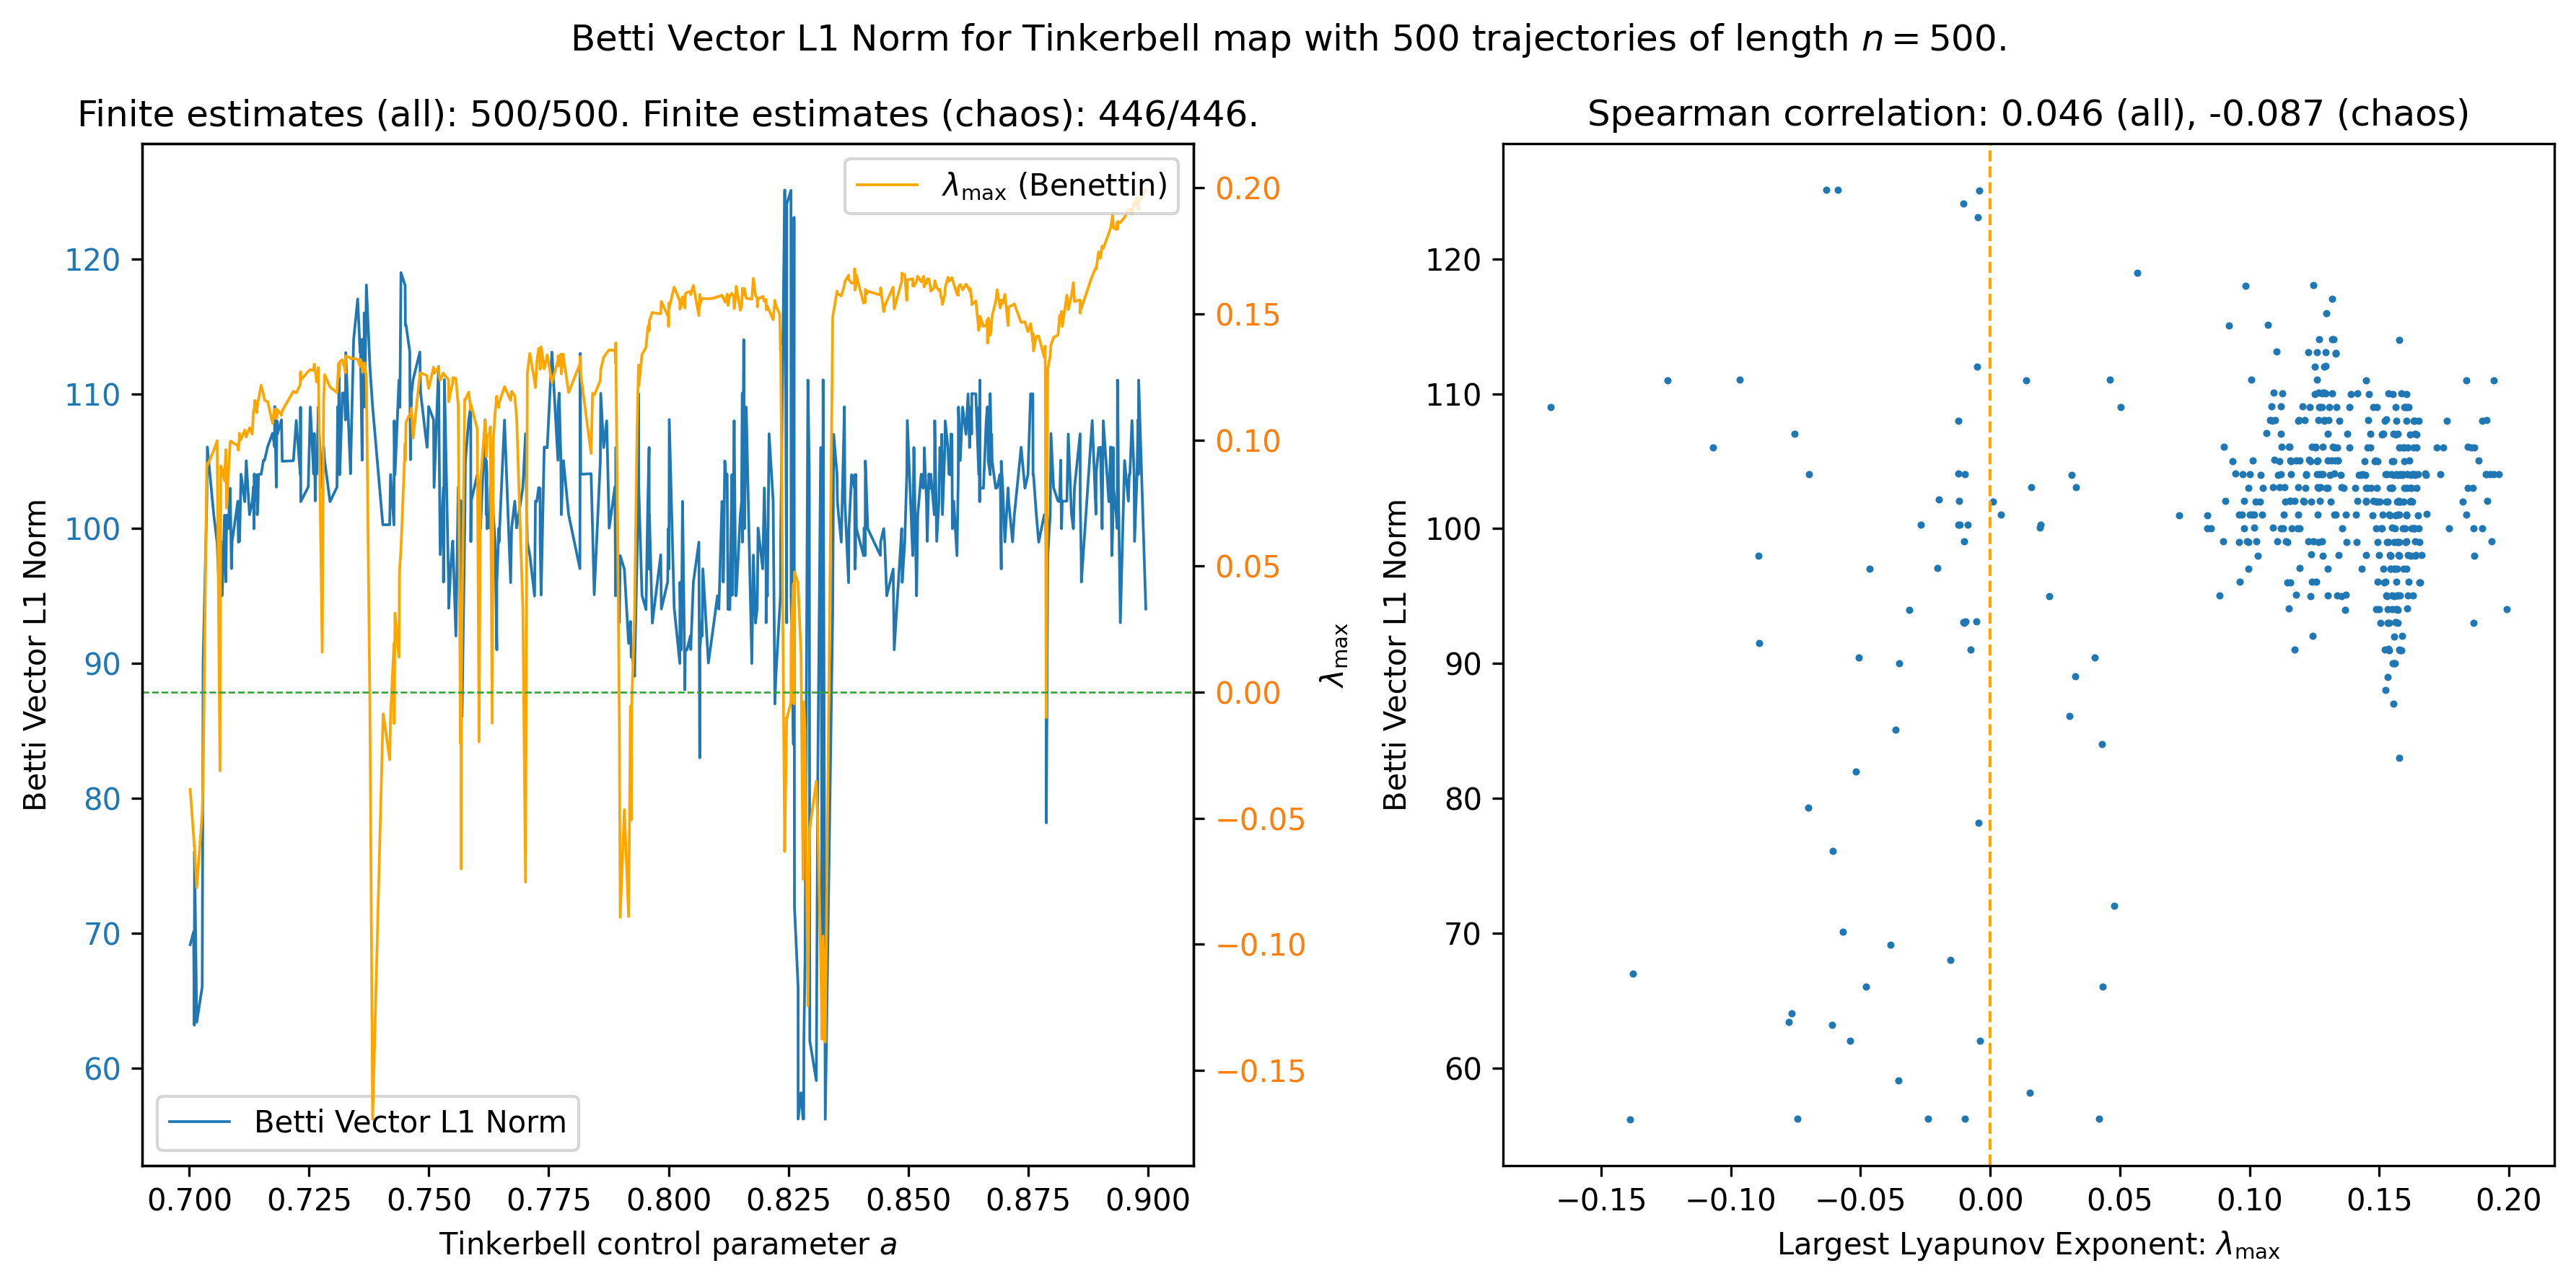

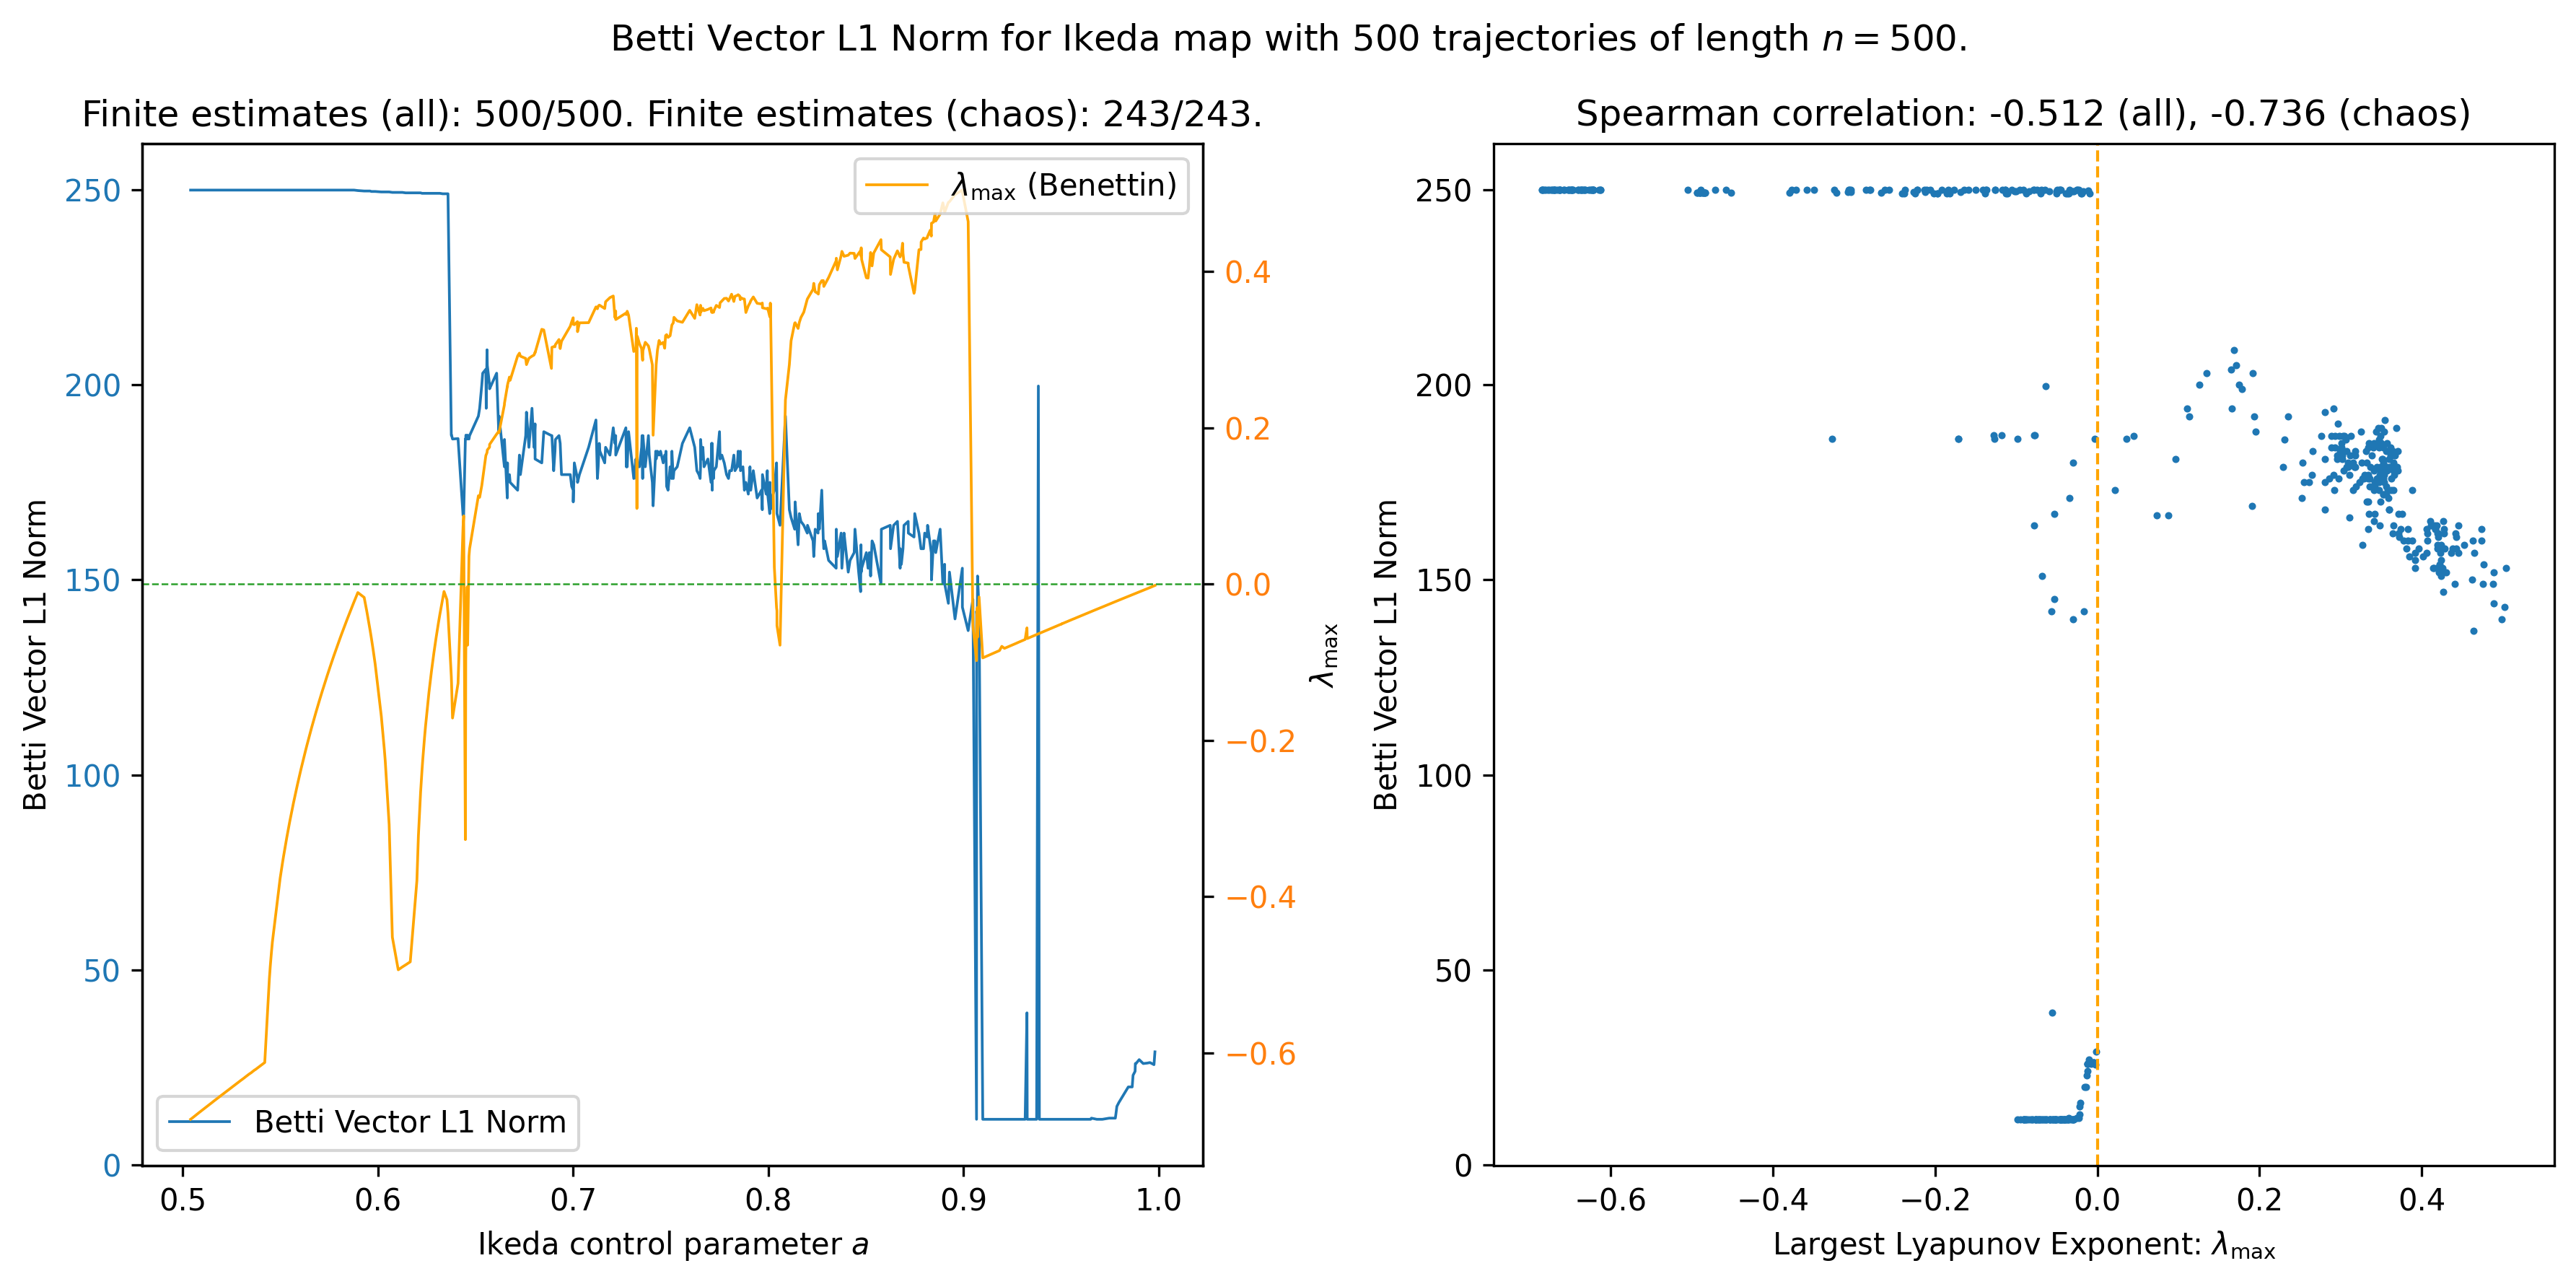

In [47]:
all_results_betti = {}
for sys_info in [
    ["Logistic", "r", logistic_trajectories, logistic_control_params, logistic_lces],
    ["Hénon", "a", henon_trajectories, henon_control_params, henon_lces],
    ["Tinkerbell", "a", tinkerbell_trajectories, tinkerbell_control_params, tinkerbell_lces],
    ["Ikeda", "a", ikeda_trajectories, ikeda_control_params, ikeda_lces],
]:
    all_results_betti |= generate_betti_norm_estimates(*sys_info, save_plot=True)

In [48]:
with open(f"outputs/data/BETTI_benchmarks_{time_series_length}.pkl", "wb") as file:
    pickle.dump(all_results_betti, file)

for result in all_results_betti:
    print(result, all_results_betti[result])

('Betti Vector L1 Norm', 'Logistic', 500) {'spearmanr': SpearmanrResult(correlation=-0.58438785815437, pvalue=4.0144911142708603e-47), 'pos_spearmanr': SpearmanrResult(correlation=-0.8150326726431752, pvalue=7.476426399661684e-92), 'classification_f1': 0.7440689134051116, 'regression_neg_mean_absolute': -0.23896388330411658, 'pos_regression_neg_mean_absolute': -0.10688178109094973, 'regression_neg_mean_absolute_poly': -0.2721263750478823, 'pos_regression_neg_mean_absolute_poly': -0.10936550140234709}
('Betti Vector L1 Norm', 'Hénon', 500) {'spearmanr': SpearmanrResult(correlation=-0.8084658845277322, pvalue=9.875187260501125e-117), 'pos_spearmanr': SpearmanrResult(correlation=-0.7609497885481886, pvalue=1.144492549377428e-45), 'classification_f1': 0.7690539549110265, 'regression_neg_mean_absolute': -0.10201251665267021, 'pos_regression_neg_mean_absolute': -0.06922616767409345, 'regression_neg_mean_absolute_poly': -0.07418913961460216, 'pos_regression_neg_mean_absolute_poly': -0.0722137